In [28]:
import numpy as np
import pandas as pd
from data_preparation import get_test_runttherunway_data, get_train_runttherunway_data, get_processed_renttherunway_data

In [274]:
OTHER_CAT = "other"
class HierarchicalStatus:
    def __init__(self, alpha =0.1):
        self.alpha = alpha
        self.treshold = 100
        self.beta = 1
        self.w = np.random.beta(0.1, 1) #pd.Series(np.random.beta(0.1, 1, size=3), index=['fit', 'small', 'large'])
        #self.w = alpha/(1+alpha)
        self.best_w = self.w
        self.best_prob = -1
        self.initialized = False
        self.train = None
        self.iterations = 0
        self.history = []

    def initialize_model(self, df, return_status_column = 'result'):
        dummies = pd.get_dummies(df[return_status_column])
        labels = dummies.columns
        self.labels = labels

        default_df = df.value_counts(return_status_column)
        self.default = default_df#.div(coldstart_df.sum())
        self.default['all'] = self.default.sum()
        self.default['predicted_return_status'] = self.default[labels].idxmax()
        #self.coldstart['all'] = self.coldstart.sum()

        df_encoded = pd.concat([df, dummies], axis=1)
        self.sales_at_article_level  = df_encoded[["item_id"]+list(labels)].groupby(["item_id"]).sum().rename(columns={l: str(l)+"_by_article" for l in labels}) #+ 1
        self.sales_at_article_level["all_by_article"] = self.sales_at_article_level.sum(axis=1)
        self.sales_at_category_level  = df_encoded[["category"]+list(labels)].groupby(["category"]).sum().rename(columns={l:str(l)+'_by_category' for l in labels}) #+ 1
        self.sales_at_category_level["all_by_category"] = self.sales_at_category_level.sum(axis=1)
        hs.sales_at_category_level.loc[OTHER_CAT] = hs.sales_at_category_level.sum()

        self.initialized = True
        # self.sales_probability_by_fit = sales_by_fit.div(sales_by_fit.sum(axis=1), axis=0)
        # self.sales_probability_by_fit['predicted_result'] = self.sales_probability_by_fit.idxmax(axis=1)
        
    def _training_step(self, lr):
        probabilities = ((self.train["count_return_status_article"]
                        +self.w * self.train["count_return_status_category"])/
                        (self.train["count_article"]+self.w *self.train["count_category"]))
        logderivatives = (self.train["count_return_status_category"]/
                            (self.train["count_return_status_article"] + 
                             self.w * self.train["count_return_status_category"])
                       - self.train["count_category"]/
                            (self.train["count_article"] + 
                             self.w * self.train["count_category"]) 
                       )
        derivatives = probabilities*logderivatives
        derivative = derivatives.mean() # mean or sum - but i think mean is better since adjusting learning rate will not be dependent on training set size
        self.history.append({"iter": self.iterations, "w": self.w, "mean_derivative": derivative, "mean_prob": probabilities.mean()})
        if self.best_prob<probabilities.mean():
            self.best_prob =probabilities.mean()
            self.best_w = self.w
        new_w = self.w + lr*derivative
        if 0 <= new_w <= 1:
            self.w += lr * derivative
        else:
            self.w = np.random.beta(self.alpha, self.beta)
        self.iterations +=1

    def prepare_trainset(self, df, return_status_column ='result'):
        self.train = df
        self.train["original_category"] = df["category"]
        self.train["count_category"] = (self.sales_at_category_level["all_by_category"])[self.train["category"]].values
        self.train.loc[self.train["count_category"]<self.treshold, "category"] = "other"
        self.train["count_category"] = (self.sales_at_category_level["all_by_category"])[self.train["category"]].values
        self.train["count_return_status_category"] = self.train.apply(
            lambda row: self.sales_at_category_level[str(row[return_status_column])+"_by_category"][row["category"]], axis=1
        )
        self.train["count_article"] = self.sales_at_article_level["all_by_article"][self.train["item_id"]].values
        self.train["count_return_status_article"] = self.train.apply(
            lambda row: self.sales_at_article_level[str(row[return_status_column])+"_by_article"][row["item_id"]], axis=1
        )
        #self.train["new_category"] = self.train["category"]


    def train_model(self,  df=None, lr=0.01, T=100, log_every = 10, return_status_column = "result"):
        if not self.initialized:
            self.initialize_model(df, return_status_column)
            print("Model initiated")
        if df is not None:
            self.prepare_trainset(df, return_status_column) 
            print("Trainset prepared")
        for iteration in range(T):
            if (iteration+1)%log_every==0:
                print(iteration, self.history[-1])
            self._training_step(lr)


        
    def predict(self, df):
        prediction = df.merge(self.sales_at_article_level, how='left', on='item_id')
        prediction = prediction.merge(self.sales_at_category_level, how='left', on='category')
        prediction = prediction.fillna(self.default.rename({l: str(l)+"_by_article" for l in list(self.labels)+['all']}))

        for status in self.labels:
            prediction[status] = ((prediction[str(status)+"_by_article"] + self.w *prediction[str(status)+'_by_category'])
                                / (prediction["all_by_article"] + self.w * prediction["all_by_category"]))
        

        prediction['predicted_return_status'] = prediction[self.labels].idxmax(axis=1)
        return prediction


In [269]:
hs.sales_at_category_level

,0_by_category,1_by_category,2_by_category,all_by_category
category,,,,
ballgown,10.0,5.0,1.0,16.0
blazer,595.0,117.0,70.0,782.0
blouse,484.0,107.0,60.0,651.0
blouson,11.0,2.0,1.0,14.0
bomber,94.0,14.0,20.0,128.0
...,...,...,...,...
trouser,35.0,6.0,14.0,55.0
trousers,13.0,0.0,5.0,18.0
tunic,104.0,53.0,5.0,162.0


In [272]:
hs.sales_at_category_level.loc[OTHER_CAT] = hs.sales_at_category_level.sum()

In [273]:
hs.sales_at_category_level

,0_by_category,1_by_category,2_by_category,all_by_category
category,,,,
ballgown,10.0,5.0,1.0,16.0
blazer,595.0,117.0,70.0,782.0
blouse,484.0,107.0,60.0,651.0
blouson,11.0,2.0,1.0,14.0
bomber,94.0,14.0,20.0,128.0
...,...,...,...,...
trousers,13.0,0.0,5.0,18.0
tunic,104.0,53.0,5.0,162.0
turtleneck,25.0,8.0,1.0,34.0


In [242]:
df = get_processed_renttherunway_data()

In [256]:
df.value_counts("category").values

array([92884, 44381, 19316,  5365,  5184,  4931,  3443,  3070,  2404,
        1751,  1531,  1149,   980,   782,   729,   651,   464,   422,
         278,   277,   241,   205,   188,   181,   162,   128,   125,
         123,   112,   107,   103,    87,    84,    75,    58,    57,
          55,    48,    48,    39,    34,    30,    22,    20,    18,
          17,    17,    16,    16,    15,    14,    14,    13,    12,
           8,     8,     7,     7,     7,     6,     6,     5,     4,
           4,     2,     2,     1,     1])

In [260]:
hs.default["all"]

192544

In [265]:
hs.train.loc[df["count_category"]<100, "category"] = "other"

In [266]:
hs.train

,result_original,user_id_original,item_id_original,size,review_date,category,user_id,item_id,result,count_category,count_return_status_category,count_article,count_return_status_article
0,fit,420272,2260466,14,"April 20, 2016",romper,44334,4396,0,3070.0,2248.0,28.0,19.0
1,fit,273551,153475,12,"June 18, 2013",gown,28835,65,0,44381.0,35177.0,519.0,408.0
2,fit,360448,1063761,4,"December 14, 2015",sheath,37976,1945,0,19316.0,14549.0,81.0,59.0
3,fit,909926,126335,8,"February 12, 2014",dress,96080,7,0,92884.0,66567.0,2241.0,1678.0
4,fit,151944,616682,12,"September 26, 2016",gown,15959,1032,0,44381.0,35177.0,114.0,108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
192539,fit,66386,2252812,8,"May 18, 2016",jumpsuit,7026,4382,0,5184.0,3866.0,44.0,41.0
192540,fit,118398,682043,4,"September 30, 2016",dress,12494,1164,0,92884.0,66567.0,68.0,52.0
192541,fit,47002,683251,8,"March 4, 2016",dress,5019,1166,0,92884.0,66567.0,130.0,95.0
192542,fit,961120,126335,16,"November 25, 2015",dress,101534,7,0,92884.0,66567.0,2241.0,1678.0


In [264]:
hs.train.value_counts("count_category")

count_category
92884.0     92884
44381.0     44381
19316.0     19316
5365.0       5365
5184.0       5184
4931.0       4931
3443.0       3443
3070.0       3070
2404.0       2404
1751.0       1751
1531.0       1531
1149.0       1149
980.0         980
192544.0      877
782.0         782
729.0         729
651.0         651
464.0         464
422.0         422
278.0         278
277.0         277
241.0         241
205.0         205
188.0         188
181.0         181
162.0         162
128.0         128
125.0         125
123.0         123
112.0         112
107.0         107
103.0         103
dtype: int64

In [301]:
#corr_df = pd.DataFrame(df, columns=["category", "result"])
corrMatrix = pd.crosstab(index=hs.train["category"], columns=df["result"])
corrMatrix

result,0,1,2
category,,,
dress,66567,12631,13686
gown,35177,4467,4737
jacket,1681,361,362
jumpsuit,3866,646,672
maxi,2605,552,286
mini,1300,131,320
other,4921,1677,537
romper,2248,479,343
sheath,14549,1634,3133


In [303]:
from scipy.stats import chi2_contingency
ChiSqResult = chi2_contingency(corrMatrix)
ChiSqResult

(2621.5561596444336,
 0.0,
 24,
 array([[68529.35054845, 11918.75617002, 12435.89328154],
        [32744.07978436,  5694.91319906,  5942.00701658],
        [ 1773.65917401,   308.47820758,   321.86261841],
        [ 3824.72926708,   665.20425461,   694.06647831],
        [ 2540.22817642,   441.80135969,   460.97046389],
        [ 1291.87904063,   224.68608214,   234.43487722],
        [ 5264.16730721,   915.55408115,   955.27861164],
        [ 2265.03064235,   393.9384764 ,   411.03088125],
        [14251.24817185,  2478.60443327,  2586.14739488],
        [ 3958.27016163,   688.42994329,   718.29989509],
        [ 1129.56414118,   196.45596331,   204.9798955 ],
        [  847.72645214,   147.43821153,   153.83533634],
        [ 3638.06713271,   632.73961796,   660.19324934]]))

In [234]:
corr_df

,category,result
0,romper,0
1,gown,0
2,sheath,0
3,dress,0
4,gown,0
...,...,...
192539,jumpsuit,0
192540,dress,0
192541,dress,0
192542,dress,0


In [224]:
pd.DataFrame(hs.history)

,iter,w,mean_derivative,mean_prob
0,0,0.026547,-0.207953,0.591583
1,1,0.005752,-1.569774,0.602726


<AxesSubplot:xlabel='w', ylabel='mean_derivative'>

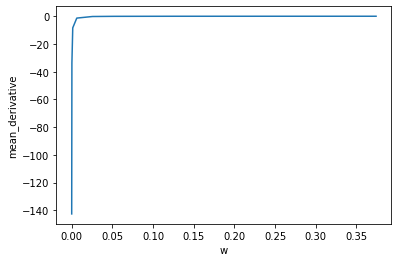

In [297]:
#sns.lineplot(data=pd.DataFrame(hs.history), x="w", y="mean_prob")
sns.lineplot(data=pd.DataFrame(hs.history), x="w", y="mean_derivative")

<AxesSubplot:xlabel='w', ylabel='mean_prob'>

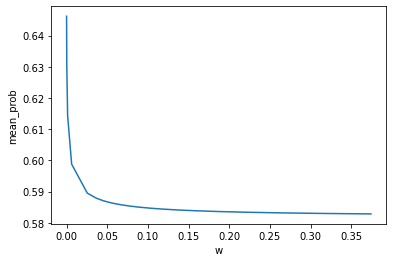

In [298]:
sns.lineplot(data=pd.DataFrame(hs.history), x="w", y="mean_prob")

<AxesSubplot:xlabel='iter', ylabel='mean_prob'>

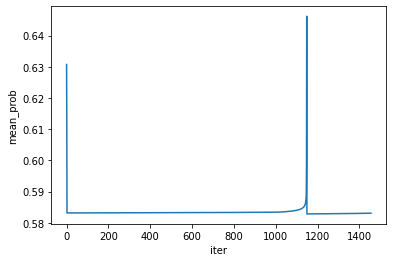

In [299]:
sns.lineplot(data=pd.DataFrame(hs.history), x="iter", y="mean_prob")

<AxesSubplot:xlabel='iter', ylabel='mean_derivative'>

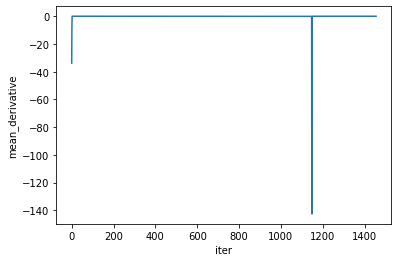

In [300]:
sns.lineplot(data=pd.DataFrame(hs.history), x="iter", y="mean_derivative")

In [229]:
hs.best_w

6.323979469202434e-44

In [285]:
hs = HierarchicalStatus()
hs.treshold = 1000
hs.train_model(df, 0.01, log_every=100,T=1000)


Model initiated
Trainset prepared
99 {'iter': 98, 'w': 0.2654352203312278, 'mean_derivative': -0.004088656161787711, 'mean_prob': 0.5831435873524874}
199 {'iter': 198, 'w': 0.26128880606646676, 'mean_derivative': -0.004206764822036708, 'mean_prob': 0.5831607837139217}
299 {'iter': 298, 'w': 0.2570199230748764, 'mean_derivative': -0.004333859624757972, 'mean_prob': 0.5831790111336509}
399 {'iter': 398, 'w': 0.2526190320447267, 'mean_derivative': -0.0044710901609067025, 'mean_prob': 0.583198383563178}
499 {'iter': 498, 'w': 0.2480753425900365, 'mean_derivative': -0.004619818785512924, 'mean_prob': 0.5832190338975876}
599 {'iter': 598, 'w': 0.2433765755155987, 'mean_derivative': -0.00478167346135848, 'mean_prob': 0.5832411182931716}
699 {'iter': 698, 'w': 0.23850866435555845, 'mean_derivative': -0.00495861745098567, 'mean_prob': 0.5832648217654138}
799 {'iter': 798, 'w': 0.2334553762348749, 'mean_derivative': -0.005153042558715527, 'mean_prob': 0.5832903655453601}
899 {'iter': 898, 'w': 0

In [286]:
hs.best_w

0.00027604886240535653

In [287]:
hs.train_model(lr=0.1, log_every=100,T=1000)


99 {'iter': 1098, 'w': 0.14716510278106085, 'mean_derivative': -0.011636289041805283, 'mean_prob': 0.583957667211514}
199 {'iter': 1198, 'w': 0.36310607990594373, 'mean_derivative': -0.0023070447184480817, 'mean_prob': 0.5828437466079328}
299 {'iter': 1298, 'w': 0.33855186274716553, 'mean_derivative': -0.0026240530650747827, 'mean_prob': 0.5829041597524328}
399 {'iter': 1398, 'w': 0.31020885099470397, 'mean_derivative': -0.0030796239506224567, 'mean_prob': 0.5829847284814426}


KeyboardInterrupt: 

In [334]:
hs.w=0.00001

In [335]:
full_results = hs.predict(df)

In [336]:
full_results

,result_original,user_id_original,item_id_original,size,review_date,category,user_id,item_id,result,count_category,...,2_by_article,all_by_article,0_by_category,1_by_category,2_by_category,all_by_category,0,1,2,predicted_return_status
0,fit,420272,2260466,14,"April 20, 2016",romper,44334,4396,0,3070.0,...,9.0,28.0,2248.0,479.0,343.0,3070.0,0.678630,0.000171,0.321199,0
1,fit,273551,153475,12,"June 18, 2013",gown,28835,65,0,44381.0,...,41.0,519.0,35177.0,4467.0,4737.0,44381.0,0.786133,0.134846,0.079022,0
2,fit,360448,1063761,4,"December 14, 2015",sheath,37976,1945,0,19316.0,...,20.0,81.0,14549.0,1634.0,3133.0,19316.0,0.728454,0.024834,0.246712,0
3,fit,909926,126335,8,"February 12, 2014",dress,96080,7,0,92884.0,...,106.0,2241.0,66567.0,12631.0,13686.0,92884.0,0.748760,0.203899,0.047342,0
4,fit,151944,616682,12,"September 26, 2016",gown,15959,1032,0,44381.0,...,3.0,114.0,35177.0,4467.0,4737.0,44381.0,0.946768,0.026604,0.026628,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192539,fit,66386,2252812,8,"May 18, 2016",jumpsuit,7026,4382,0,5184.0,...,0.0,44.0,3866.0,646.0,672.0,5184.0,0.931599,0.068248,0.000153,0
192540,fit,118398,682043,4,"September 30, 2016",dress,12494,1164,0,92884.0,...,12.0,68.0,66567.0,12631.0,13686.0,92884.0,0.764059,0.059863,0.176078,0
192541,fit,47002,683251,8,"March 4, 2016",dress,5019,1166,0,92884.0,...,33.0,130.0,66567.0,12631.0,13686.0,92884.0,0.730669,0.016240,0.253091,0
192542,fit,961120,126335,16,"November 25, 2015",dress,101534,7,0,92884.0,...,106.0,2241.0,66567.0,12631.0,13686.0,92884.0,0.748760,0.203899,0.047342,0


In [337]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def create_confusion_matrix(result_df,target_column, prediction_column):
    labels = result_df[target_column].unique()
    confusion_m = pd.DataFrame(confusion_matrix(result_df[target_column], result_df[prediction_column], labels=labels), 
                                index=['true_'+str(l) for l in labels], 
                                columns=['predicted_'+str(l) for l in labels])
    return confusion_m
def show_confusion_matrix(results,target_column, prediction_column):
    confusion_m = create_confusion_matrix(results,target_column, prediction_column)
    sns.heatmap(confusion_m, annot=True, fmt='d')
def compute_mean_target_probability(results):
    return results.apply(lambda row: row[row['result']], axis=1).mean()

def compute_mean_log_probability(results):
    #return np.log(results.apply(lambda row: row[row['result']], axis=1)).mean()
    return results.apply(lambda row: np.log(row[row['result']]), axis=1).mean()


sgd + wykres 

------ Return status results ------
Mean target probability:  0.6479162635348422
Mean target log probability:  -0.5949550786508874


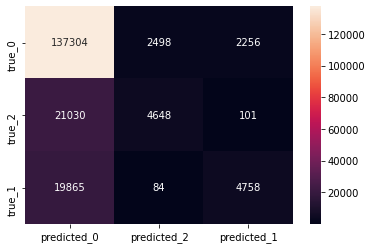

In [338]:
print("------ Return status results ------")
print("Mean target probability: ", compute_mean_target_probability( full_results))
print("Mean target log probability: ", compute_mean_log_probability(full_results))
show_confusion_matrix(full_results, "result", "predicted_return_status")